##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 言語理解のためのTransformerモデル

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

このチュートリアルでは、ポルトガル語を英語に翻訳する<a href="https://arxiv.org/abs/1706.03762" class="external">Transformerモデル</a>を訓練します。これは上級編のサンプルで、[テキスト生成](text_generation.ipynb)や[アテンション（注意機構）](nmt_with_attention.ipynb)の知識を前提としています。

Transformerモデルの背後にある中心的なアイデアは*セルフアテンション（自己注意）*、 つまり、シーケンスの表現を計算するために入力シーケンスの異なる位置に注意を払うことができることにあります。

Transformerモデルは、[RNNs](text_classification_rnn.ipynb)や[CNNs](../images/intro_to_cnns.ipynb)の代わりに セルフアテンション・レイヤーを重ねたものを使って、可変長の入力を扱います。この一般的なアーキテクチャにはいくつもの利点があります。

* データの中の時間的／空間的な関係を前提にしません。これは、オブジェクトの集合（例えば、[StarCraftのユニット](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8))を扱うには理想的です。
* レイヤーの出力はRNNのような系列ではなく、並列に計算可能です。
* たくさんのRNNのステップや畳み込み層を経ることなく、離れた要素どうしが互いの出力に影響を与えることができます（例えば、[Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf)を参照)。
* 長距離の依存関係を学習可能です。これは、シーケンスを扱うタスクにおいては難しいことです。

このアーキテクチャの欠点は次のようなものです。

* 時系列では、あるタイムステップの出力が、入力とその時の隠れ状態だけからではなく、*過去全て*から計算されます。
* テキストのように、入力に時間的／空間的な関係が*存在する*場合、何らかの位置エンコーディングを追加しなければなりません。さもなければ、モデルは実質的にバッグ・オブ・ワード（訳注：Bag of Word、含まれる単語の集合）を見ることになります。

このノートブックのモデルを訓練したあとには、ポルトガル語の文を入力し、英語の翻訳を得ることができます。

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [2]:
!pip install tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

## 入力パイプラインの設定

[TFDS](https://www.tensorflow.org/datasets)を使って、[TED Talks Open Translation Project](https://www.ted.com/participate/translate)から[Portugese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt)をロードします。

このデータセットには、約50000の訓練用サンプルと、1100の検証用サンプル、2000のテスト用サンプルが含まれています。

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

訓練用データセットから、カスタムのサブワード・トークナイザーを作成します。

In [7]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [8]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


このトークナイザーは、単語が辞書にない場合には文字列をサブワードに分解してエンコードします。

In [9]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [10]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

入力とターゲットに開始及び終了トークンを追加します。

In [11]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

データセットの各要素にこの関数を適用するために、`Dataset.map`を使いたいと思います。`Dataset.map`はグラフモードで動作します。

* グラフテンソルは値を持ちません。
* グラフモードでは、TensorFlowの演算と関数しか使えません。

このため、この関数を直接`.map`することはできません。`tf.py_function`でラップする必要があります。`tf.py_function`は（値とそれにアクセスするための`.numpy()`メソッドを持つ）通常のテンソルを、ラップされたPython関数に渡します。

In [12]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

Note: このサンプルを小さく、より速くするため、長さが40トークンを超えるサンプルを削除します。

In [13]:
MAX_LENGTH = 40

In [14]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [15]:
train_preprocessed = (
    train_examples
    .map(tf_encode) 
    .filter(filter_max_length)
    # 読み取り時のスピードアップのため、データセットをメモリ上にキャッシュする
    .cache()
    .shuffle(BUFFER_SIZE))

val_preprocessed = (
    val_examples
    .map(tf_encode)
    .filter(filter_max_length))        

パディングとバッチ化の両方を行います。

In [16]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))


val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))

Note: **TensorFlow 2.2** から、padded_shapes は必須ではなくなりました。デフォルトではすべての軸をバッチ中で最も長いものに合わせてパディングします。

In [17]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE)
                 .prefetch(tf.data.experimental.AUTOTUNE))


val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE))

後でコードをテストするために、検証用データセットからバッチを一つ取得しておきます。

In [18]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## 位置エンコーディング

このモデルには再帰や畳込みが含まれないので、モデルに文中の単語の相対的な位置の情報を与えるため、位置エンコーディングを追加します。

位置エンコーディングベクトルは埋め込みベクトルに加算します。埋め込みはトークンをd次元空間で表現します。そこでは、同じような意味を持つトークンが近くに位置することになります。しかし、埋め込みは単語の文中の相対的位置をエンコードしません。したがって、位置エンコーディングを加えることで、単語は、d次元空間の中で、*意味と文中の位置の近さ*にもとづいて近くに位置づけられます。

もう少し知りたければ [位置エンコーディング](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) のノートブックを参照してください。位置エンコーディングを計算する式は下記のとおりです。

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [19]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [20]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # 配列中の偶数インデックスにはsinを適用; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # 配列中の奇数インデックスにはcosを適用; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


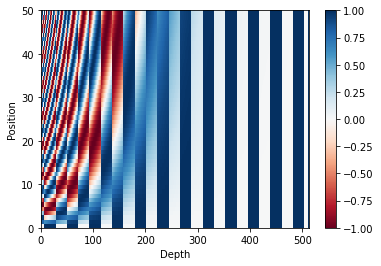

In [21]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## マスキング

シーケンスのバッチ中のパディングされた全てのトークンをマスクします。これにより、モデルがパディングを確実に入力として扱わないようにします。マスクは、パディング値`0`の存在を示します。つまり、`0`の場所で`1`を出力し、それ以外の場所では`0`を出力します。

In [22]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # アテンション・ロジットにパディングを追加するため
  # さらに次元を追加する
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [23]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

シーケンス中の未来のトークンをマスクするため、 ルックアヘッド・マスクが使われています。言い換えると、このマスクはどのエントリーを使うべきではないかを示しています。

これは、3番めの単語を予測するために、1つ目と2つ目の単語だけが使われるということを意味しています。同じように4つ目の単語を予測するには、1つ目、2つ目と3つ目の単語だけが使用され、次も同様となります。

In [24]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [25]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## スケール済み内積アテンション

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Transformerで使われているアテンション関数は3つの入力；Q(query), K(key), V(value)を取ります。このアテンションの重みの計算に使われている式は下記の通りです。

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

内積アテンションは、深度の平方根をファクターとしてスケールされています。これは、深度が大きくなると、内積が非常に大きくなり、ソフトマックス関数の勾配を計算すると非常に小さな値しか返さなくなってしまうためです。

例えば、`Q`と`K`が平均0分散1だと思ってください。これらの行列積は、平均0分散は`dk`となります。したがって、（他の数字ではなく）*`dk`の平方根*をスケーリングに使うことで、`Q` と `K` の行列積においても平均 0 分散 1 となり、緩やかな勾配を持つソフトマックスが得られることが期待できるのです。

マスクには、（負の無限大に近い）-1e9が掛けられています。これは、マスクがQとKのスケール済み行列積と合計され、ソフトマックスの直前に適用されるからです。目的は、これらのセルをゼロにしてしまうことで、大きなマイナスの入力は、ゼロに近い出力となります。

In [26]:
def scaled_dot_product_attention(q, k, v, mask):
  """アテンションの重みの計算
  q, k, vは最初の次元が一致していること
  k, vは最後から2番めの次元が一致していること
  マスクは型（パディングかルックアヘッドか）によって異なるshapeを持つが、
  加算の際にブロードキャスト可能であること
  引数：
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: (..., seq_len_q, seq_len_k) にブロードキャスト可能な
          shapeを持つ浮動小数点テンソル。既定値はNone
  
  戻り値：
    出力、アテンションの重み
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # matmul_qkをスケール
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # マスクをスケール済みテンソルに加算
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax は最後の軸(seq_len_k)について
  # 合計が1となるように正規化
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

ソフトマックス正規化がKに対して行われるため、その値がQに割り当てる重要度を決めることになります。

出力は、アテンションの重みとV(value)ベクトルの積を表しています。これにより、注目したい単語がそのまま残され、それ以外の単語は破棄されます。

In [27]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [28]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# この`query`は2番目の`key`に割り付けられているので
# 2番めの`value`が返される
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [29]:
# このクエリは（3番目と 4番目の）繰り返しキーに割り付けられるので
# 関連した全ての値が平均される
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [30]:
# このクエリは最初と2番めのキーに等しく割り付けられるので
# それらの値が平均される
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


すべてのクエリをまとめます。

In [31]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## マルチヘッド・アテンション

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


マルチヘッド・アテンションは4つのパートから成っています。
* 線形レイヤーとマルチヘッドへの分割
* スケール済み内積アテンション
* マルチヘッドの結合
* 最終線形レイヤー


各マルチヘッド・アテンション・ブロックは3つの入力：Q(query), K(key), V(value)を取ります。
これらは、線形（Dense）レイヤーを通され、マルチヘッドに分割されます。

上記で定義した`scaled_dot_product_attention`は（効率のためにブロードキャストで）各ヘッドに適用されます。アテンション・ステップにおいては、適切なマスクを使用しなければなりません。その後、各ヘッドのアテンション出力は（`tf.transpose`と`tf.reshape`を使って）結合され、最後の`Dense`レイヤーに通されます。

単一のアテンション・ヘッドのかわりに、Q、K、およびVは複数のヘッドに分割されます。なぜなら、それによって、モデルが異なる表現空間の異なる位置の情報について、連携してアテンションを計算できるからです。また、分割後の各ヘッドの次元を小さくすることで、全体の計算コストを、すべての次元を持つ単一のアテンション・ヘッドを用いた場合と同一にできます。

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """最後の次元を(num_heads, depth)に分割。
    結果をshapeが(batch_size, num_heads, seq_len, depth)となるようにリシェイプする。
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

試しに、`MultiHeadAttention`レイヤーを作ってみましょう。シーケンス `y` の各位置において、`MultiHeadAttention` はシーケンスのすべての位置に対して8つのヘッドを用いてアテンションを計算し、各位置それぞれで同じ長さの新しいベクトルを返します。

In [33]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## ポイントワイズのフィードフォワード・ネットワーク

ポイントワイズのフィードフォワード・ネットワークは、2つの全結合層とそれをつなぐReLU活性化層からなります。

In [34]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [35]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## エンコーダーとデコーダー

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Transformerモデルは、標準の[アテンション付きシーケンス・トゥー・シーケンスモデル](nmt_with_attention.ipynb)と同じ一般的なパターンを踏襲します。

* 入力の文は、`N`層のエンコーダー・レイヤーを通り、シーケンス中の単語／トークンごとに出力を生成する。
* デコーダーは、エンコーダーの出力と自分自身の入力（セルフアテンション）に注目し、次の単語を予測する。

### エンコーダー・レイヤー

それぞれのエンコーダー・レイヤーは次のようなサブレイヤーから成っています。

1.  マルチヘッド・アテンション（パディング・マスク付き）
2.  ポイントワイズ・フィードフォワード・ネットワーク

サブレイヤーにはそれぞれ残差接続があり、その後にレイヤー正規化が続きます。残差接続は、深いネットワークでの勾配消失問題を回避するのに役立ちます。

それぞれのサブレイヤーの出力は`LayerNorm(x + Sublayer(x))`です。正規化は、（最後の）`d_model`軸に対して行われます。TransformerにはN層のエンコーダーがあります。

In [36]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [37]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### デコーダー・レイヤー

各デコーダー・レイヤーは次のようなサブレイヤーからなります。

1. マスク付きマルチヘッド・アテンション（ ルックアヘッド・マスクおよびパディング・マスク付き）
2. （パディング・マスク付き）マルチヘッド・アテンション。V(value) と K(key) は*エンコーダーの出力*を入力として受け取る。Q(query)は*マスク付きマルチヘッド・アテンション・サブレイヤー*の出力を受け取る。
3. ポイントワイズ・フィードフォワード・ネットワーク

各サブレイヤーは残差接続を持ち、その後にレイヤー正規化が続きます。各サブレイヤーの出力は`LayerNorm(x + Sublayer(x))`です。正規化は、（最後の）`d_model`軸に沿って行われます。

Transformerには、N層のデコーダー・レイヤーが存在します。

Qがデコーダーの最初のアテンション・ブロックの出力を受け取り、Kがエンコーダーの出力を受け取るとき、アテンションの重みは、デコーダーの入力の、エンコーダーの出力に対する重要度を表します。言い換えると、デコーダーは、エンコーダーの出力と自分自身の出力のセルフ・アテンションを見て、次の単語を予想します。上記の、スケール済み内積アテンションのセクションのデモを参照してください。

In [38]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [39]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### エンコーダー

`Encoder`は次のものからできています。

1.  入力の埋め込み
2.  位置エンコーディング
3.  N 層のエンコーダー・レイヤー

入力は埋め込み層を通り、位置エンコーディングと合算されます。この加算の出力がエンコーダー・レイヤーの入力です。エンコーダーの出力はデコーダーの入力になります。

In [40]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # 埋め込みと位置エンコーディングを合算する
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [41]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### デコーダー

`Decoder` は次のもとからできています。
 
1.   出力埋め込み
2.   位置エンコーディング
3.   N 層のデコーダー・レイヤー

ターゲットは埋め込みを通り、位置エンコーディングと加算されます。この加算の出力がデコーダーの入力になります。デコーダーの出力は、最後の線形レイヤーの入力となります。

In [42]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [43]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformerの作成

 Transformerは、エンコーダー、デコーダーと、最後の線形レイヤーからなります。デコーダーの出力は、線形レイヤーの入力であり、その出力が返されます。

In [44]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [45]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## ハイパーパラメーターの設定

このサンプルを小さく、比較的高速にするため、 *num_layers, d_model, and dff*の値は小さくされています。

Transformerのベースモデルで使われている値は*num_layers=6*, *d_model = 512*, *dff = 2048*です。 Transformerの他のバージョンについては、[論文](https://arxiv.org/abs/1706.03762)を参照してください。

Note: 下記の値を変更することで、さまざまなタスクでSoTA（訳注：State of The Art、その時点での最高性能）を達成したモデルが得られます。

In [46]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## オプティマイザー

[論文](https://arxiv.org/abs/1706.03762)の中の式に従って、カスタムの学習率スケジューラーを持った、Adamオプティマイザーを使用します。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [48]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

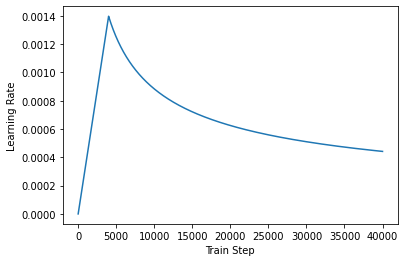

In [49]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 損失とメトリクス

ターゲットシーケンスはパディングされているため、損失を計算する際にパディング・マスクを適用することが重要です。

In [50]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [51]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [52]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 訓練とチェックポイント生成

In [53]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [54]:
def create_masks(inp, tar):
  # Encoderパディング・マスク
  enc_padding_mask = create_padding_mask(inp)
  
  # デコーダーの 2つ目のアテンション・ブロックで使用
  # このパディング・マスクはエンコーダーの出力をマスクするのに使用
  dec_padding_mask = create_padding_mask(inp)
  
  # デコーダーの 1つ目のアテンション・ブロックで使用
  # デコーダーが受け取った入力のパディングと将来のトークンをマスクするのに使用
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

チェックポイントのパスとチェックポイント・マネージャーを作成します。これは、`n`エポックごとにチェックポイントを保存するのに使用されます。

In [55]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# チェックポイントが存在したなら、最後のチェックポイントを復元
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

ターゲットは、tar_inpとtar_realに分けられます。tar_inpはデコーダーの入力として渡されます。`tar_real`は同じ入力を1つシフトしたものです。`tar_input`の位置それぞれで、`tar_real`は予測されるべき次のトークンを含んでいます。

たとえば、`sentence` = "SOS A lion in the jungle is sleeping EOS" だとすると、次のようになります。

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

Transformerは、自己回帰モデルです。1回に1箇所の予測を行い、その出力を次に何をすべきかの判断に使用します。

訓練時にこのサンプルは[テキスト生成チュートリアル](./text_generation.ipynb)のように、ティーチャーフォーシングを使用します。ティーチャーフォーシングとは、その時点においてモデルが何を予測したかに関わらず、真の出力を次のステップに渡すというものです。

Transformerが単語を予測するたびに、*セルフアテンション*のおかげで次の単語を予測するために入力シーケンスの過去の単語を参照することができます。

モデルが期待される出力を盗み見ることがないように、モデルはルックアヘッド・マスクを使用します。

In [56]:
EPOCHS = 20

In [57]:
# @tf.functionは高速に実行するためにtrain_stepをTFグラフにトレースコンパイルします。
# この関数は、引数となるテンソルのshapeに特化したものです。
# シーケンスの長さや（最後のバッチが小さくなるなど）バッチサイズが可変となることによって
# 再トレーシングが起きないようにするため、input_signatureを使って、より一般的なshapeを
# 指定します。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

ポルトガル語を入力言語とし、英語をターゲット言語とします。

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.6535 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.1667 Accuracy 0.0021
Epoch 1 Batch 100 Loss 4.1453 Accuracy 0.0129
Epoch 1 Batch 150 Loss 4.1038 Accuracy 0.0176
Epoch 1 Batch 200 Loss 4.0451 Accuracy 0.0201
Epoch 1 Batch 250 Loss 3.9765 Accuracy 0.0220
Epoch 1 Batch 300 Loss 3.8987 Accuracy 0.0245
Epoch 1 Batch 350 Loss 3.8140 Accuracy 0.0290
Epoch 1 Batch 400 Loss 3.7281 Accuracy 0.0330
Epoch 1 Batch 450 Loss 3.6494 Accuracy 0.0361
Epoch 1 Batch 500 Loss 3.5847 Accuracy 0.0390
Epoch 1 Batch 550 Loss 3.5263 Accuracy 0.0423
Epoch 1 Batch 600 Loss 3.4659 Accuracy 0.0459
Epoch 1 Batch 650 Loss 3.4104 Accuracy 0.0493
Epoch 1 Batch 700 Loss 3.3603 Accuracy 0.0526
Epoch 1 Loss 3.3591 Accuracy 0.0527
Time taken for 1 epoch: 992.2440252304077 secs

Epoch 2 Batch 0 Loss 2.8276 Accuracy 0.1031
Epoch 2 Batch 50 Loss 2.5617 Accuracy 0.1016
Epoch 2 Batch 100 Loss 2.5329 Accuracy 0.1052
Epoch 2 Batch 150 Loss 2.5283 Accuracy 0.1076
Epoch 2 Batch 200 Loss 2.5062 Accuracy 0.1091
Ep

## 評価

評価は次のようなステップで行われます。

* ポルトガル語のトークナイザー(`tokenizer_pt`)を使用して入力文をエンコードします。さらに、モデルの訓練に使用されたものと同様に、開始および終了トークンを追加します。これが、入力のエンコードです。
* デコーダーの入力は、`start token == tokenizer_en.vocab_size`です。
* パディング・マスクとルックアヘッド・マスクを計算します。
* `decoder`は、`encoder output`と自分自身の出力（セルフアテンション）を見て、予測値を出力します。
* 最後の単語を選択し、そのargmaxを計算します。
* デコーダーの入力に予測された単語を結合し、デコーダーに渡します。
* このアプローチでは、デコーダーは自分自身が予測した過去の単語にもとづいて次の単語を予測します。

Note: ここで使われているモデルは、より早く実行できるようにした能力の低いものであるため、予測はあまり正確ではありません。論文の結果を再現するには、データセット全体を使用し、上記のハイパーパラメーターを変更して、ベースのTransformerモデルまたはTransformer XLを使用します。

In [ ]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp文はポルトガル語、開始および終了トークンを追加
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # ターゲットは英語であるため、Transformerに与える最初の単語は英語の
  # 開始トークンとなる
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # seq_len次元から最後の単語を選択
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # predicted_idが終了トークンと等しいなら結果を返す
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # 出力にpredicted_idを結合し、デコーダーへの入力とする
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # アテンションの重みをプロット
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [ ]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [ ]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

In [ ]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

In [ ]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

パラメータを`plot`するために、異なるレイヤーやデコーダーのアテンション・ブロックを渡すことができます。

In [ ]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

## まとめ

このチュートリアルでは、位置エンコーディング、マルチヘッド・アテンション、マスキングの重要性と、 Transformerの作成方法を学習しました。

Transformerを訓練するために、異なるデータセットを使ってみてください。また、上記のハイパーパラメーターを変更してベースTransformerやTransformer XLを構築することもできます。ここで定義したレイヤーを使って[BERT](https://arxiv.org/abs/1810.04805)を構築して、SoTAのモデルを作ることもできます。さらには、より良い予測を得るために、ビームサーチを組み込むこともできます。